#Install required libraries

<div dir=rtl>
در این سلول، کتابخانه های مورد نیاز بترتیب برای پیش پردازش متن ها و نیز ایجاد اپتیمایزر نصب میشوند.
</div>

In [1]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.6 MB 37.9 MB/s 
     |████████████████████████████████| 511.7 MB 6.7 kB/s 
     |████████████████████████████████| 1.6 MB 65.3 MB/s 
     |████████████████████████████████| 438 kB 74.4 MB/s 
     |████████████████████████████████| 5.8 MB 61.9 MB/s 
     |████████████████████████████████| 2.1 MB 30.8 MB/s 
     |████████████████████████████████| 1.2 MB 57.8 MB/s 
     |████████████████████████████████| 352 kB 64.6 MB/s 
     |████████████████████████████████| 237 kB 64.5 MB/s 
     |████████████████████████████████| 99 kB 3.1 MB/s 
     |████████████████████████████████| 636 kB 47.0 MB/s 
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 92 kB 11.9 MB/s 
     |████████████████████████████████| 1.1 MB 59.5 MB/s 


#Import required libraries

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  


tf.get_logger().setLevel('ERROR')

#Download dataset

<div dir=rtl>
در ابتدا آدرس دیتاست آی ام دی بی در متغیر یو ار ال ذخیره میگردد. سپس دیتاست مذکور دانلود شده و در فایل سیستم ذخیره میگردد.
</div>

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')

shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 8s 0us/step


#Data prepration

<div dir=rtl>
داده های دانلود شده به سه قسمت تست و ترین و ولیدیشن ذخیره میشوند. بچ سایز داده ها برابر 64 میباشد و سید استفاده شده برای تکرار داده های انتخاب شده برای تست و ترین و ولیدیشن در هر بار اجرای برنامه است. در واقع از سید برای تکراری انجام شدن تسک هایی که با مقدار دهی اولیه رندوم سرو کار دارند استفاده میشود.
</div>

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


#Print 3 sample from dataset (text & label)

<div dir=rtl>
در این سلول سه نمونه از داده های ترین بهمراه کلاس آنها چاپ شده است.
</div>

In [5]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"First of all, I liked very much the central idea of locating the '' intruders'', Others in the fragile Self, on various levels - mainly subconscious but sometimes more allegorical. In fact the intruders are omnipresent throughout the film : in the Swiss-French border where the pretagonist leads secluded life; in the his recurring daydream and nightmare; inside his ailing body after heart transplantation.... In the last half of the film, he becomes intruder himself, returning in ancient french colony in the hope of atoning for the past. <br /><br />The overall tone is bitter rather than pathetic, full of regrets and guilts, sense of failure being more or less dominant. This is a quite grim picture of an old age, ostensibly self-dependent but hopelessly void and lonely inside. The directer composes the images more to convey passing sensations of anxiety and desire than any explicit meanings. Some of them are mesmerizing, not devoid of humor though, kind of absurdist play only s

#Download bert preprocess model layer from tensorflow hub

<div dir=rtl>
در این سلول لایه ای از طبقه بند دانلود میشود که بوسیله آن به هر کلمه یک آیدی یکتا تخصیص داده میشود. بنابراین جملات ورودی به این لایه تبدیل به برداری میشوند که این بردار به تعداد کلمات جمله ورودی، عدد صحیح غیر صفر دارد و هر کدام از این اعداد صحیح صرفا مختص یک کلمه هستند.
</div>

In [6]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#Print a sample of vectorized texts (first 12 from each vector)

<div dir=rtl>
در این سلول کاربرد لایه دانلود شده در سلول قبلی نشان داده شده است.
</div>

In [7]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#Download a pretrained layer of bert model from tensorflow hub


<div dir=rtl>
در این سلول لایه برت آموزش دیده دانلود میشود. این لایه وظیفه ایجاد بردار امبدینگ جملات تبدیل شده به بردار اعداد صحیح را دارد.
</div>

In [8]:
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

#Print a sample of embeddong 

<div dir=rtl>
در این سلول یک نمونه از تبدیل بردار اعداد صحیح یه جمله به بردار امبدینگ نمایش داده شده است.
</div>

In [9]:
bert_results = bert_model(text_preprocessed)
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


#Classifier definition

<div dir=rtl>
در این سلول معماری طبقه بند ایجاد شده است. همانطور که مشخص است، در ابتدا یک لایه ورودی ایجاد شده است، سپس لایه تبدیل جمله به بردار اعداد صحیح ایجاد شده است، سپس لایه امبدینگ توسط برت اضافه شده استو در نهایت یک لایه دراپ اوت و تمام متصل اضافه شده و ایجاد معماری مدل به اتمام رسیده است.
</div>

In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

#Initialization classifier

<div dir=rtl>
در این سلول خروجی شبکه به ازای متن نمونه و تابع فعالساز خروجی سیگمویید نشان داده شده است.
</div>

In [11]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.67695546]], shape=(1, 1), dtype=float32)


#Print model diagram

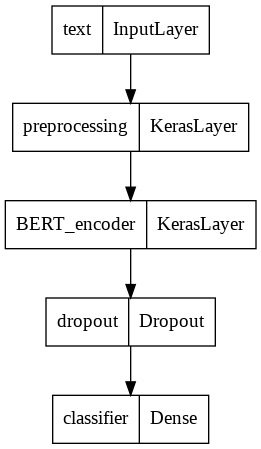

In [12]:
tf.keras.utils.plot_model(classifier_model)

# Loss function and optimizer definition

<div dir=rtl>
در این سلول به ترتیب تعداد دوره های آموزش شبکه، مقدار اولیه نرخ آموزش، تعداد گام ها در هر دوره آموزش، تعداد کل گام های آموزش، تعداد گام های وارم آپ (تعداد گام های وارم آپ تعداد دفعات آپدیت نرخ آموزش را تعیین میکند)، تابع هزینه (با توجه به تعداد نورون های لایه خروجی، از نوع باینری میباشد)، متریک برای تعیین پرفرومنس مدل در هنگام آموزش و تست و بهینه سازتعیین شده است
</div>

In [13]:
epochs = 5
init_lr = 3e-5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

#Model compile and train

In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
313/313 [==============================] - 181s 557ms/step - loss: 0.5252 - binary_accuracy: 0.7247 - val_loss: 0.3795 - val_binary_accuracy: 0.8270
Epoch 2/5
313/313 [==============================] - 173s 554ms/step - loss: 0.3668 - binary_accuracy: 0.8378 - val_loss: 0.3755 - val_binary_accuracy: 0.8386
Epoch 3/5
313/313 [==============================] - 173s 553ms/step - loss: 0.2991 - binary_accuracy: 0.8725 - val_loss: 0.3678 - val_binary_accuracy: 0.8470
Epoch 4/5
313/313 [==============================] - 173s 553ms/step - loss: 0.2494 - binary_accuracy: 0.8985 - val_loss: 0.3920 - val_binary_accuracy: 0.8520
Epoch 5/5
313/313 [==============================] - 174s 557ms/step - loss: 0.2145 - binary_accuracy: 0.9148 - val_loss: 0.4069 - val_binary_accuracy: 0.8510


#Model evaluation

In [15]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

391/391 [==============================] - 111s 284ms/step - loss: 0.3866 - binary_accuracy: 0.8572
Loss: 0.38659846782684326
Accuracy: 0.8571599721908569
